In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

torch.manual_seed(0)#make training results repeatable

In [22]:
class Ghost_Batch_Norm(nn.Module): #https://arxiv.org/pdf/1705.08741v2.pdf has what seem like typos in GBN definition. 
    def __init__(self, features, ghost_batch_size=32, number_of_ghost_batches=0, n_averaging=1, stride=1, eta=0.9, bias=True, device='cpu', name='', conv=False, features_out=None): # number_of_ghost_batches was initially set to 64
        super(Ghost_Batch_Norm, self).__init__()
        self.name = name
        self.index = None
        self.stride = stride
        self.device = device
        self.features = features
        self.features_out = features_out if features_out is not None else self.features
        self.register_buffer('ghost_batch_size', torch.tensor(ghost_batch_size, dtype=torch.long))
        self.register_buffer('n_ghost_batches', torch.tensor(number_of_ghost_batches*n_averaging, dtype=torch.long))
        self.conv = False
        self.gamma = None
        self.bias = None
        self.updates = 0
        if conv:
            self.conv = nn.Conv1d(self.features, self.features_out, stride, stride=stride, bias=bias)
        else:
            self.gamma = nn.Parameter(torch .ones(self.features))
            if bias:
                self.bias = nn.Parameter(torch.zeros(self.features))
        self.running_stats = True
        self.initialized   = False

        self.register_buffer('eps',  torch.tensor(1e-5, dtype=torch.float))
        self.register_buffer('eta',  torch.tensor(eta, dtype=torch.float))
        self.register_buffer('m',    torch.zeros((1,1,self.stride,self.features), dtype=torch.float))
        self.register_buffer('s',    torch.ones ((1,1,self.stride,self.features), dtype=torch.float))
        self.register_buffer('zero', torch.tensor(0., dtype=torch.float))
        self.register_buffer('one',  torch.tensor(1., dtype=torch.float))
        self.register_buffer('two',  torch.tensor(2., dtype=torch.float))

    def print(self):
        print('-'*50)
        print(self.name)
        for i in range(self.stride):
            print(" mean ",end='')
            vector_print(self.m[0,0,i,:])
        for i in range(self.stride):
            print("  std ", end='')
            vector_print(self.s[0,0,i,:])
        if self.gamma is not None:
            print("gamma ", end='')
            vector_print(self.gamma.data)
            if self.bias is not None:
                print(" bias ", end='')
                vector_print(self.bias.data)
        print()
        
    @torch.no_grad()
    def set_mean_std(self, x):
        batch_size = x.shape[0]
        pixels = x.shape[2]
        pixel_groups = pixels//self.stride
        x = x.detach().transpose(1,2).contiguous().view(batch_size*pixels, 1, self.features)
        # this won't work for any layers with stride!=1
        x = x.view(-1, 1, self.stride, self.features)            
        m64 = x.mean(dim=0, keepdim=True, dtype=torch.float64)#.to(self.device)
        self.m = m64.type(torch.float32).to(self.device)
        self.s = x .std(dim=0, keepdim=True).to(self.device)
        self.initialized = True
        self.running_stats = False
        self.print()        

    def set_ghost_batches(self, n_ghost_batches):
        self.n_ghost_batches = torch.tensor(n_ghost_batches, dtype=torch.long).to(self.device)

    def forward(self, x, debug=False):
        batch_size = x.shape[0]
        pixels = x.shape[2]
        pixel_groups = pixels//self.stride

        if self.training and self.n_ghost_batches!=0:
            # this has been changed from self.ghost_batch_size = batch_size // self.n_ghost_batches.abs()
            self.ghost_batch_size = torch.div(batch_size, self.n_ghost_batches.abs(), rounding_mode = 'trunc')

            #
            # Apply batch normalization with Ghost Batch statistics
            #
            x = x.transpose(1,2).contiguous().view(self.n_ghost_batches.abs(), self.ghost_batch_size*pixel_groups, self.stride, self.features)
            
            gbm =  x.mean(dim=1, keepdim=True)
            gbs = (x. var(dim=1, keepdim=True) + self.eps).sqrt()

            #
            # Keep track of running mean and standard deviation. 
            #
            if self.running_stats or debug:
                # Use mean over ghost batches for running mean and std
                bm = gbm.detach().mean(dim=0, keepdim=True)
                bs = gbs.detach().mean(dim=0, keepdim=True)

                if debug and self.initialized:
                    gbms = gbm.detach().std(dim=0, keepdim=True)
                    gbss = gbs.detach().std(dim=0, keepdim=True)
                    m_pulls = (bm-self.m)/gbms
                    s_pulls = (bs-self.s)/gbss
                    #s_ratio = bs/self.s
                    #if (m_pulls.abs()>5).any() or (s_pulls.abs()>5).any():
                    print()
                    print(self.name)
                    print('self.m\n',self.m)
                    print('    bm\n', bm)
                    print('  gbms\n',gbms)
                    print('m_pulls\n',m_pulls,m_pulls.abs().mean(),m_pulls.abs().max())
                    print('-------------------------')
                    print('self.s\n',self.s)
                    print('    bs\n',bs)
                    print('  gbss\n',gbss)
                    print('s_pulls\n',s_pulls,s_pulls.abs().mean(),s_pulls.abs().max())
                    #print('s_ratio\n',s_ratio)
                    print()
                    #input()
                    
            if self.running_stats:
                # Simplest possible method
                if self.initialized:
                    self.m = self.eta*self.m + (self.one-self.eta)*bm
                    self.s = self.eta*self.s + (self.one-self.eta)*bs
                else:
                    self.m = self.zero*self.m+bm
                    self.s = self.zero*self.s+bs
                    self.initialized = True

            if self.n_ghost_batches>0:
                x = x - gbm
                x = x / gbs
            else:
                x = x.view(batch_size, pixel_groups, self.stride, self.features)
                x = x - self.m
                x = x / self.s
                
        else:
            # Use mean and standard deviation buffers rather than batch statistics
            #.view(self.n_ghost_batches, self.ghost_batch_size*pixel_groups, self.stride, self.features)
            x = x.transpose(1,2).view(batch_size, pixel_groups, self.stride, self.features)
            x = x - self.m
            x = x / self.s

        if self.conv:
            # back to standard indexing for convolutions: [batch, feature, pixel]
            x = x.view(batch_size, pixels, self.features).transpose(1,2).contiguous()
            x = self.conv(x)
        else:
            x = x * self.gamma
            if self.bias is not None:
                x = x + self.bias
            # back to standard indexing for convolutions: [batch, feature, pixel]
            x = x.view(batch_size, pixels, self.features).transpose(1,2).contiguous()
        return x            

    
#
# some basic four-vector operations
#
def PxPyPzE(v): # need this to be able to add four-vectors
    pt  = v[:,0:1]
    eta = v[:,1:2]
    phi = v[:,2:3]
    m   = v[:,3:4]
    
    Px, Py, Pz = pt*phi.cos(), pt*phi.sin(), pt*eta.sinh()
    E = (pt**2 + Pz**2 + m**2).sqrt()

    return torch.cat( (Px,Py,Pz,E), 1 )


def PtEtaPhiM(v):
    px = v[:,0:1]
    py = v[:,1:2]
    pz = v[:,2:3]
    e  = v[:,3:4]

    Pt  = (px**2+py**2).sqrt()
    ysign = 1-2*(py<0).float() # if py==0, px==Pt and acos(1)=pi/2 so we need zero protection on py.sign() --> changed to the current shape to avoid 0-gradient of .sign()
    Phi = (px/Pt).acos() * ysign
    Eta = (pz/Pt).asinh()

    M = F.relu(e**2 - px**2 - py**2 - pz**2).sqrt()

    return torch.cat( (Pt, Eta, Phi, M) , 1 ) 
    

def addFourVectors(v1, v2, v1PxPyPzE=None, v2PxPyPzE=None): # output added four-vectors
    #vX[batch index, (pt,eta,phi,m), object index]

    if v1PxPyPzE is None:
        v1PxPyPzE = PxPyPzE(v1)
    if v2PxPyPzE is None:
        v2PxPyPzE = PxPyPzE(v2)

    v12PxPyPzE = v1PxPyPzE + v2PxPyPzE
    v12        = PtEtaPhiM(v12PxPyPzE)

    return v12, v12PxPyPzE

def calcDeltaPhi(v1, v2): #expects eta, phi representation
    dPhi12 = (v1[:,2:3]-v2[:,2:3])%math.tau
    dPhi21 = (v2[:,2:3]-v1[:,2:3])%math.tau
    dPhi = torch.min(dPhi12,dPhi21)
    return dPhi

def setLeadingEtaPositive(batched_v) -> torch.Tensor: # expects [batch, feature, jet nb]
    etaSign = 1-2*(batched_v[:,1,0:1]<0).float() # -1 if eta is negative, +1 if eta is zero or positive
    batched_v[:,1,:] = etaSign * batched_v[:,1,:]
    return batched_v

def setLeadingPhiTo0(batched_v) -> torch.Tensor: # expects [batch, feature, jet nb]
    # set phi = 0 for the leading jet and rotate the event accordingly
    phi_ref = batched_v[:,2,0:1] # get the leading jet phi for each event
    batched_v[:,2,:] = batched_v[:,2,:] - phi_ref # rotate all phi to make phi_lead = 0
    batched_v[:,2,:][batched_v[:,2,:]>torch.pi] -= 2*torch.pi # retransform the phi that are > pi
    batched_v[:,2,:][batched_v[:,2,:]<-torch.pi] += 2*torch.pi # same for the phi that are < -pi
    return batched_v

def setSubleadingPhiPositive(batched_v) -> torch.Tensor: # expects [batch, feature, jet nb]
    phiSign = 1-2*(batched_v[:,2,1:2]<0).float() # -1 if phi2 is negative, +1 if phi2 is zero or positive
    batched_v[:,2,1:4] = phiSign * batched_v[:,2,1:4]
    return batched_v

#
# Some different non-linear units
#
def SiLU(x): #SiLU https://arxiv.org/pdf/1702.03118.pdf   Swish https://arxiv.org/pdf/1710.05941.pdf
    return x * torch.sigmoid(x)


def NonLU(x): #Pick the default non-Linear Unit
    return SiLU(x) # often slightly better performance than standard ReLU
    #return F.relu(x)
    #return F.rrelu(x, training=training)
    #return F.leaky_relu(x, negative_slope=0.1)
    #return F.elu(x)
    

class Input_Embed(nn.Module):
    def __init__(self, dimension, device='cpu'):
        super(Input_Embed, self).__init__()
        self.d = dimension
        self.device = device

        # embed inputs to dijetResNetBlock in target feature space
        self.jet_embed     = Ghost_Batch_Norm(3, features_out=self.d, conv=True, name='jet embedder', device=self.device) # phi is relative to dijet, mass is zero in toy data. # 3 features -> 8 features
        self.jet_conv      = Ghost_Batch_Norm(self.d, conv=True, name='jet convolution', device = self.device)

        self.dijet_embed   = Ghost_Batch_Norm(4, features_out=self.d, conv=True, name='dijet embedder', device = self.device) # phi is relative to quadjet, # 4 features -> 8 features
        self.dijet_conv    = Ghost_Batch_Norm(self.d, conv=True, name='dijet convolution', device = self.device) 

        self.quadjet_embed = Ghost_Batch_Norm(3, features_out=self.d, conv=True, name='quadjet embedder', device = self.device) # phi is removed. # 3 features -> 8 features
        self.quadjet_conv  = Ghost_Batch_Norm(self.d, conv=True, name='quadjet convolution', device = self.device)

        #self.register_buffer('tau', torch.tensor(math.tau, dtype=torch.float))

    
        
    def data_prep(self, j):
        j = j.clone()# prevent overwritting data from dataloader when doing operations directly from RAM rather than copying to VRAM
        j = j.view(-1,4,4)

        d, dPxPyPzE = addFourVectors(j[:,:,(0,2,0,1,0,1)], 
                                     j[:,:,(1,3,2,3,3,2)])

        q, qPxPyPzE = addFourVectors(d[:,:,(0,2,4)],
                                     d[:,:,(1,3,5)], 
                                     v1PxPyPzE = dPxPyPzE[:,:,(0,2,4)],
                                     v2PxPyPzE = dPxPyPzE[:,:,(1,3,5)])        

        # take log of pt, mass variables which have long tails
        j[:,(0,3),:] = torch.log(1+j[:,(0,3),:])
        d[:,(0,3),:] = torch.log(1+d[:,(0,3),:])
        q[:,(0,3),:] = torch.log(1+q[:,(0,3),:])

        # set up all possible jet pairings
        j = torch.cat([j, j[:,:,(0,2,1,3)], j[:,:,(0,3,1,2)]],2)

        
        # only keep relative angular information so that learned features are invariant under global phi rotations and eta/phi flips
        j[:,2:3,(0,2,4,6,8,10)] = calcDeltaPhi(d, j[:,:,(0,2,4,6,8,10)]) # replace jet phi with deltaPhi between dijet and jet
        j[:,2:3,(1,3,5,7,9,11)] = calcDeltaPhi(d, j[:,:,(1,3,5,7,9,11)])
        
        
        d[:,2:3,(0,2,4)] = calcDeltaPhi(q, d[:,:,(0,2,4)])
        d[:,2:3,(1,3,4)] = calcDeltaPhi(q, d[:,:,(1,3,5)])

        q = torch.cat( (q[:,:2,:],q[:,3:,:]) , 1 ) # remove phi from quadjet features

        return j, d, q

    def set_mean_std(self, j):
        j, d, q = self.data_prep(j)

        self    .jet_embed.set_mean_std(j[:,0:3])#mass is always zero in toy data
        self  .dijet_embed.set_mean_std(d)
        self.quadjet_embed.set_mean_std(q)

    def set_ghost_batches(self, n_ghost_batches):
        self.    jet_embed.set_ghost_batches(n_ghost_batches)
        self.  dijet_embed.set_ghost_batches(n_ghost_batches)
        self.quadjet_embed.set_ghost_batches(n_ghost_batches)

        self.    jet_conv.set_ghost_batches(n_ghost_batches)
        self.  dijet_conv.set_ghost_batches(n_ghost_batches)
        self.quadjet_conv.set_ghost_batches(n_ghost_batches)

    def forward(self, j):
        j, d, q = self.data_prep(j)

        j = self    .jet_embed(j[:,0:3])#mass is always zero in toy data
        d = self  .dijet_embed(d)
        q = self.quadjet_embed(q)

        j = self    .jet_conv(NonLU(j))
        d = self  .dijet_conv(NonLU(d))
        q = self.quadjet_conv(NonLU(q))

        return j, d, q


class Basic_CNN(nn.Module):
    def __init__(self, dimension, n_classes=2, device='cpu'):
        super(Basic_CNN, self).__init__()
        self.device = device
        self.d = dimension
        self.n_classes = n_classes
        self.n_ghost_batches = 64

        self.name = f'Basic_CNN_{self.d}'

        self.input_embed = Input_Embed(self.d)

        self.jets_to_dijets     = Ghost_Batch_Norm(self.d, stride=2, conv=True, device = self.device)
        self.dijets_to_quadjets = Ghost_Batch_Norm(self.d, stride=2, conv=True, device = self.device)

        self.select_q = Ghost_Batch_Norm(self.d, features_out=1, conv=True, bias=False, device = self.device)
        self.out      = Ghost_Batch_Norm(self.d, features_out=self.n_classes, conv=True, device = self.device)

    def set_mean_std(self, j):
        self.input_embed.set_mean_std(j)

    def set_ghost_batches(self, n_ghost_batches):
        self.input_embed.set_ghost_batches(n_ghost_batches)
        self.jets_to_dijets.set_ghost_batches(n_ghost_batches)
        self.dijets_to_quadjets.set_ghost_batches(n_ghost_batches)
        self.select_q.set_ghost_batches(n_ghost_batches)
        self.out.set_ghost_batches(n_ghost_batches)
        self.n_ghost_batches = n_ghost_batches

    def forward(self, j):
        j, d, q = self.input_embed(j)

        d = d + NonLU(self.jets_to_dijets(j))
        q = q + NonLU(self.dijets_to_quadjets(d))

        #compute a score for each event quadjet
        q_logits = self.select_q(q)

        #convert the score to a 'probability' with softmax. This way the classifier is learning which pairing is most relevant to the classification task at hand.
        q_score = F.softmax(q_logits, dim=-1)
        q_logits = q_logits.view(-1, 3)

        #add together the quadjets with their corresponding probability weight
        e = torch.matmul(q, q_score.transpose(1,2))

        #project the final event-level pixel into the class score space
        c_logits = self.out(e)
        c_logits = c_logits.view(-1, self.n_classes)

        return c_logits, q_logits


class Basic_CNN_AE(nn.Module):
    def __init__(self, dimension, out_features = 12, device = 'cpu', construct_rel_features = False):
        super(Basic_CNN_AE, self).__init__()
        self.device = device
        self.d = dimension
        self.out_features = out_features
        self.n_ghost_batches = 64
        self.construct_rel_features = construct_rel_features


        self.name = f'Basic_CNN_AE_{self.d}'

        self.input_embed            = Input_Embed(self.d)
        self.jets_to_dijets         = Ghost_Batch_Norm(self.d, stride=2, conv=True, device = self.device)
        self.dijets_to_quadjets     = Ghost_Batch_Norm(self.d, stride=2, conv=True, device = self.device)
        
        self.select_q               = Ghost_Batch_Norm(self.d, features_out=1, conv=True, bias=False, device = self.device)
        
        # any kind of self.out should convert a [batch_size, 8, 1] into a [batch_size, 16, 1]
        '''self.out_lin = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(in_features = self.d, out_features = 10, device = self.device),
            nn.LeakyReLU(),
            nn.Linear(in_features = 10, out_features = self.out_features, device = self.device),
            nn.Unflatten(dim = 1, unflattened_size = (self.out_features, 1))
        )'''
        
        self.decode_q               = nn.ConvTranspose1d(self.d, self.d, 3)
        self.dijets_from_quadjets   = nn.ConvTranspose1d(self.d, self.d, 2, stride = 2)
        self.decode_d               = nn.ConvTranspose1d(self.d, self.d, 6)
        self.jets_from_dijets       = nn.ConvTranspose1d(self.d, self.d, 2, stride = 2)
        self.decode_j               = nn.ConvTranspose1d(self.d, self.d, 12)

        self.select_dec             = Ghost_Batch_Norm(self.d, features_out=1, conv=True, bias=False, device = self.device)

        self.decode_Px              = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(in_features = 21, out_features = 10, device = self.device),
            #nn.Dropout(p = 0.2),
            nn.ReLU(),
            nn.Linear(in_features = 10, out_features = 4, device = self.device),
            nn.Unflatten(dim = 1, unflattened_size = (4, 1))
        )

        self.decode_Py              = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(in_features = 21, out_features = 20, device = self.device),
            #nn.Dropout(p = 0.2),
            nn.ReLU(),
            nn.Linear(in_features = 20, out_features = 4, device = self.device),
            nn.Unflatten(dim = 1, unflattened_size = (4, 1))
        )

        self.decode_Pz              = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(in_features = 21, out_features = 10, device = self.device),
            #nn.Dropout(p = 0.2),
            nn.ReLU(),
            nn.Linear(in_features = 10, out_features = 4, device = self.device),
            nn.Unflatten(dim = 1, unflattened_size = (4, 1))
        )

        self.decode_E               = nn.Sequential(
            nn.Flatten(start_dim = 1),
            nn.Linear(in_features = 21, out_features = 10, device = self.device),
            #nn.Dropout(p = 0.2),
            nn.ReLU(),
            nn.Linear(in_features = 10, out_features = 4, device = self.device),
            nn.Unflatten(dim = 1, unflattened_size = (4, 1))
        )

        self.jPxPyPzE_conv          = nn.Sequential(
            nn.Conv1d(4, 4, 3, stride = 1),
            nn.ReLU(),
            nn.ConvTranspose1d(4, 4, 3, stride = 1))





    
    def set_mean_std(self, j):
        self.input_embed.set_mean_std(j)

    
    def set_ghost_batches(self, n_ghost_batches):
        self.input_embed.set_ghost_batches(n_ghost_batches)
        self.jets_to_dijets.set_ghost_batches(n_ghost_batches)
        self.dijets_to_quadjets.set_ghost_batches(n_ghost_batches)
        self.select_q.set_ghost_batches(n_ghost_batches)
        self.n_ghost_batches = n_ghost_batches

    
    def forward(self, j):
        # j.shape = [batch_size, 4, 4]
        j_rotated = j.clone()

        # make leading jet eta positive direction so detector absolute eta info is removed
        # set phi = 0 for the leading jet and rotate the event accordingly
        # set phi1 > 0 by flipping wrt the xz plane
        j_rotated = setSubleadingPhiPositive(setLeadingPhiTo0(setLeadingEtaPositive(j_rotated)))
    

        d_rotated, dPxPyPzE_rotated = addFourVectors(   j_rotated[:,:,(0,2,0,1,0,1)], 
                                                        j_rotated[:,:,(1,3,2,3,3,2)])
        q_rotated, qPxPyPzE_rotated = addFourVectors(   d_rotated[:,:,(0,2,4)],
                                                        d_rotated[:,:,(1,3,5)], 
                                                        v1PxPyPzE = dPxPyPzE_rotated[:,:,(0,2,4)],
                                                        v2PxPyPzE = dPxPyPzE_rotated[:,:,(1,3,5)])
        m2j = d_rotated[:, 3:4, :]
        m4j = q_rotated[:, 3:4, 0]

        # convert to PxPyPzE and compute means and variances
        jPxPyPzE = PxPyPzE(j_rotated)
        jPxPyPzE_scaled = jPxPyPzE.clone()
        batch_mean = jPxPyPzE.mean(dim = (0, 2))
        batch_std = jPxPyPzE.std(dim = (0, 2))

        m2j_scaled = m2j.clone() # [batch_size, 1, 6]
        m2j_mean = m2j.mean(dim = (0, 1)) # [6]
        m2j_std = m2j.std(dim = (0, 1)) # [6]
        m4j_scaled = m4j.clone() # [batch_size, 1]
        m4j_mean = m4j.mean(dim = 0) # [1]
        m4j_std = m4j.std(dim = 0) # [1]
        
        # j_rotated.shape = [batch_size, 4, 4]
        j, d, q = self.input_embed(j_rotated)                                                   # j.shape = [batch_size, 8, 12]
                                                                                                # d.shape = [batch_size, 8, 6]
                                                                                                # q.shape = [batch_size, 8, 3]
        d = d + NonLU(self.jets_to_dijets(j))                                                   # d.shape = [batch_size, 8, 6]
        q = q + NonLU(self.dijets_to_quadjets(d))                                               # q.shape = [batch_size, 8, 3]
        #compute a score for each event quadjet
        q_logits = self.select_q(q)                                                             # q_logits.shape = [batch_size, 1, 3]
        #convert the score to a 'probability' with softmax. This way the classifier is learning which pairing is most relevant to the classification task at hand.
        q_score = F.softmax(q_logits, dim=-1)                                                   # q_score.shape = [batch_size, 1, 3]
        q_logits = q_logits.view(-1, 3)
        #add together the quadjets with their corresponding probability weight
        e = torch.matmul(q, q_score.transpose(1,2))                                             # e.shape = [batch_size, 8, 1]



        dec_q = self.decode_q(e)                                                                # dec_q.shape = [batch_size, 8, 3]
        dec_d =  self.decode_d(e) + NonLU(self.dijets_from_quadjets(dec_q))                     # dec_d.shape = [batch_size, 8, 6]
        dec_j = self.decode_j(e) + NonLU(self.jets_from_dijets(dec_d))                          # dec_j.shape = [batch_size, 8, 12]
        full_dec = torch.cat((dec_q, dec_d, dec_j), dim = 2)
        selected_dec = self.select_dec(full_dec)

        rec_Px = self.decode_Px(selected_dec)
        rec_Py = self.decode_Py(selected_dec)
        rec_Pz = self.decode_Pz(selected_dec)
        rec_E = self.decode_E(selected_dec)
        rec_jPxPyPzE = torch.cat((rec_Px, rec_Py, rec_Pz, rec_E), dim = 2).permute(0,2,1)
        
        #rec_jPxPyPzE = self.jPxPyPzE_conv(rec_jPxPyPzE)

        rec_d, rec_dPxPyPzE = addFourVectors(   PtEtaPhiM(rec_jPxPyPzE)[:,:,(0,2,0,1,0,1)], 
                                                PtEtaPhiM(rec_jPxPyPzE)[:,:,(1,3,2,3,3,2)])
        rec_q, rec_qPxPyPzE = addFourVectors(   rec_d[:,:,(0,2,4)],
                                                rec_d[:,:,(1,3,5)])
        rec_m2j = rec_d[:, 3:4, :]
        rec_m2j_scaled  = rec_m2j.clone()
        rec_m4j = rec_q[:, 3:4, 0]
        rec_m4j_scaled  = rec_m4j.clone()
        
        #rec_j = rec_j.view(-1, 3, 4) # convert to 3x4 events (4 features x 4 jets)
        rec_jPxPyPzE_scaled = rec_jPxPyPzE.clone()

        for i in range(len(rec_jPxPyPzE[0, :, 0])):
            # obtained a normalized j for the computation of the loss
            jPxPyPzE_scaled[:, i, :] = (jPxPyPzE_scaled[:, i, :] - batch_mean[i]) / batch_std[i]
            rec_jPxPyPzE_scaled[:, i, :] = (rec_jPxPyPzE[:, i, :] - batch_mean[i]) / batch_std[i]
        
        for i in range(len(rec_m2j[0, 0, :])):
            m2j_scaled[:, 0, i] = (m2j_scaled[:, 0, i] - m2j_mean[i]) / m2j_std[i]
            rec_m2j_scaled[:, 0, i] = (rec_m2j[:, 0, i] - m2j_mean[i]) / m2j_std[i]
        
        m4j_scaled[:] = (m4j_scaled[:] - m4j_mean) / m4j_std
        rec_m4j_scaled[:] = (rec_m4j_scaled[:] - m4j_mean) / m4j_std

            
        
        return rec_jPxPyPzE, rec_jPxPyPzE_scaled, jPxPyPzE, jPxPyPzE_scaled, rec_m2j, rec_m2j_scaled, m2j, m2j_scaled, rec_m4j, rec_m4j_scaled, m4j, m4j_scaled

In [23]:
network = Basic_CNN_AE(8, 12, construct_rel_features = False)

In [24]:
j_input = torch.randn(100, 4, 4)

In [25]:
from torchviz import make_dot

output = network(j_input)

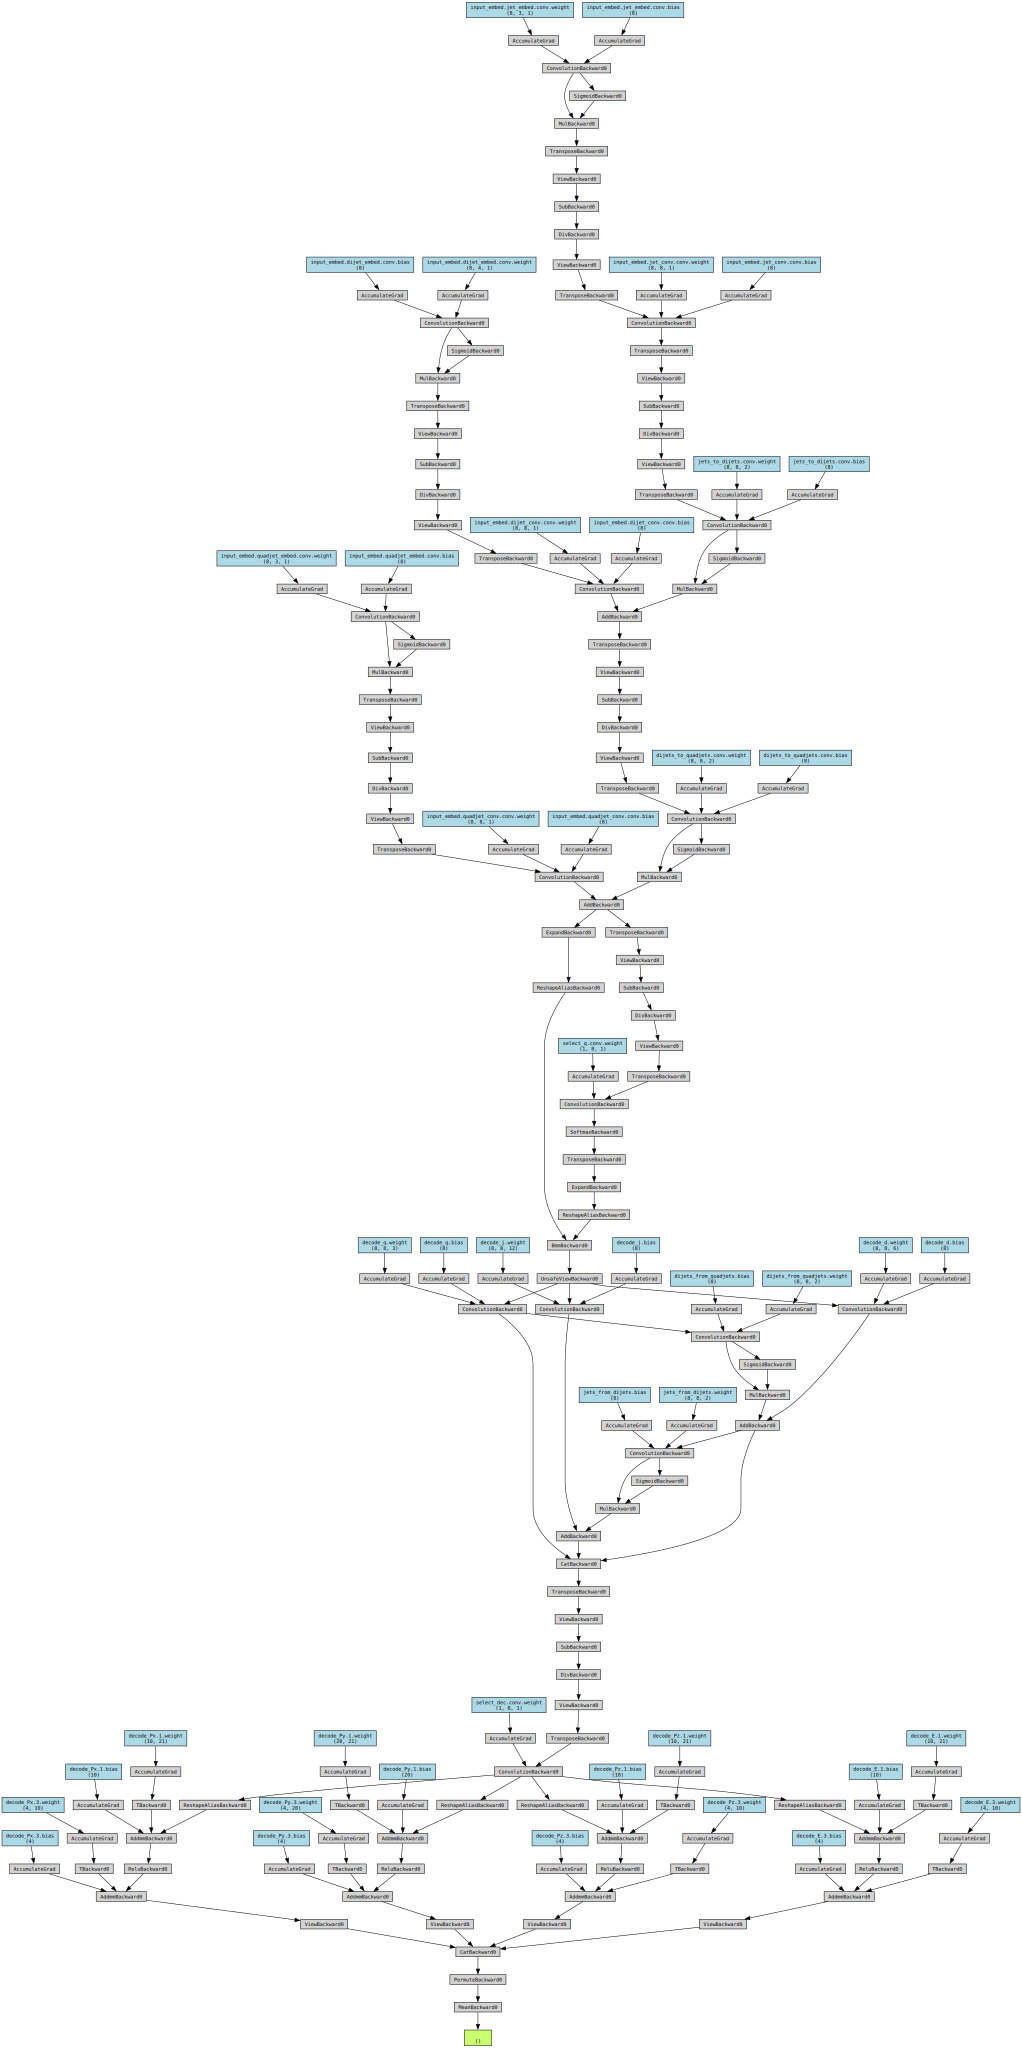

In [28]:
make_dot(output[0].mean(), params=dict(network.named_parameters()))

In [15]:
print(sigma_z)
print(torch.randn_like(sigma_z))
torch.mul(sigma_z, torch.randn_like(sigma_z))

tensor([[3.0576, 0.9652, 1.0627, 0.4647, 2.0993, 3.7565, 1.1753, 0.3940, 0.2219,
         0.5163]])
tensor([[ 0.3956,  0.0895, -0.1682, -0.4728, -1.9706,  0.6281, -0.1132,  0.4631,
          0.3338,  1.6443]])


tensor([[-3.8326, -0.0571,  1.2624,  0.5692, -1.7888, -4.4857,  1.3017,  0.2591,
         -0.0094,  0.2365]])

In [ ]:


class K_Fold(nn.Module):
    def __init__(self, models, task = 'FvT'):
        super(K_Fold, self).__init__()
        self.models = models
        for model in self.models:
            model.eval()
        self.task = task

    @torch.no_grad()
    def forward(self, j, e):

        if self.task == 'SvB' or self.task == 'FvT': # i.e. if task is classification
            c_logits = torch.zeros(j.shape[0], self.models[0].n_classes)
            q_logits = torch.zeros(j.shape[0], 3)

            for offset, model in enumerate(self.models):
                mask = (e==offset)
                c_logits[mask], q_logits[mask] = model(j[mask])

            # shift logits to have mean zero over quadjets/classes. Has no impact on output of softmax, just makes logits easier to interpret
            c_logits = c_logits - c_logits.mean(dim=-1, keepdim=True)
            q_logits = q_logits - q_logits.mean(dim=-1, keepdim=True)

            return c_logits, q_logits
        
        elif self.task == 'dec':
            rec_j = torch.zeros(j.shape[0], 3, 4) # [batch_size, 4jets, 4features]

            for offset, model in enumerate(self.models):
                #mask = (e==offset)
                if self.models[0].construct_rel_features: # check if the models were constructed with relative features
                    rec_j, rec_j_scaled, j_scaled, rel_rec_j, rel_rec_j_scaled, rel_j_scaled = model(j)
                else:
                    rec_j, rec_j_scaled, j_scaled = model(j)

            return rec_j